

# **Proyecto C: Optimización en la Planificación de Rutas Nacionales y Estrategia de Recarga para Logistico**

## Caso 3
El objetivo del Caso 3 es extender el CVRP anterior para:

- Incorporar restricciones de peso por municipio, asociadas a normativas locales.
- Incluir peajes con tarifas variables según el peso y tramo recorrido.
- Determinar estrategias conjuntas de ruteo y recarga, optimizando el costo total nacional

## Utils

In [20]:
%%capture
%pip install networkx matplotlib
%pip install haversine folium
%pip install seaborn
%pip install amplpy pyomo -q
%python -m amplpy.modules install coin highs scip gcg -q


In [21]:

from pyomo.environ import (
    ConcreteModel, RangeSet, Var, ConstraintList, Objective,
    Binary, Integers, NonNegativeReals, minimize
)
from pyomo.opt import SolverFactory

In [30]:
from haversine import haversine
import matplotlib.pyplot as plt
from amplpy import modules
from pyomo.environ import *
import pandas as pd
import folium
import requests
import itertools
from geopy.distance import geodesic
import os
import pandas as pd
from itertools import product


In [31]:
import requests
from haversine import haversine
from itertools import product


# ——————————————————————————————————————————————————————————————————
# 1) Funciones para OSRM y coordenadas
# ——————————————————————————————————————————————————————————————————
def get_coordinates(nodo, puertos, municipios, estaciones):
    if nodo in puertos:
        return puertos[nodo]['lat'], puertos[nodo]['lon']
    if nodo in municipios:
        return municipios[nodo]['lat'], municipios[nodo]['lon']
    if nodo in estaciones:
        return estaciones[nodo]['lat'], estaciones[nodo]['lon']
    raise KeyError(f"Nodo {nodo} no encontrado.")

def build_osrm_url(lat1, lon1, lat2, lon2):
    base = "http://router.project-osrm.org/route/v1/driving/"
    return f"{base}{lon1},{lat1};{lon2},{lat2}"

def get_route_info(lat1, lon1, lat2, lon2):
    url = build_osrm_url(lat1, lon1, lat2, lon2)
    try:
        resp = requests.get(url, params={'overview':'full','geometries':'geojson'})
        resp.raise_for_status()
        js = resp.json()
        route = js['routes'][0]
        dist_km = route['distance'] / 1000.0
        poly = [[lat, lon] for lon, lat in route['geometry']['coordinates']]
        return dist_km, poly
    except Exception:
        fallback = geodesic((lat1, lon1),(lat2, lon2)).kilometers
        return fallback, [[lat1, lon1], [lat2, lon2]]

def calcular_distancias_y_geometrias(puertos, municipios, estaciones, get_route_fn):
    nodos = list(puertos) + list(municipios) + list(estaciones)
    distancias, geometries = {}, {}
    for i, j in product(nodos, repeat=2):
        if i == j or (i in puertos and j in puertos):
            continue
        lat_i, lon_i = get_coordinates(i, puertos, municipios, estaciones)
        lat_j, lon_j = get_coordinates(j, puertos, municipios, estaciones)
        d, poly = get_route_fn(lat_i, lon_i, lat_j, lon_j)
        distancias[(i, j)] = d
        geometries[(i, j)] = poly
    return distancias, geometries


In [ ]:

# -----------------------------------------
# 5) Visualización en Folium (básica)
# -----------------------------------------

def visualize_rutas_folium(model, coords_dict,
                             colores_vehiculos, nombre_archivo):
    all_coords = list(coords_dict.values())
    mean_lat = sum(lat for lat,_ in all_coords)/len(all_coords)
    mean_lon = sum(lon for _,lon in all_coords)/len(all_coords)
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)
    for node, (lat,lon) in coords_dict.items():
        folium.CircleMarker([lat,lon], radius=4,
            color='blue', fill=True, fill_opacity=0.6,
            popup=str(node)
        ).add_to(m)
    for k in model.V:
        vid = f"CAM{str(k).zfill(3)}"
        color = colores_vehiculos.get(vid,'black')
        for i in model.L:
            for j in model.L:
                xval = model.x[i,j,k].value
                if xval is not None and xval>0.5:
                    lat_i, lon_i = coords_dict[i]
                    lat_j, lon_j = coords_dict[j]
                    folium.PolyLine(
                        locations=[[lat_i,lon_i],[lat_j,lon_j]],
                        color=color, weight=3, opacity=0.7
                    ).add_to(m)
    m.save(nombre_archivo)
    print(f"Mapa guardado en '{nombre_archivo}'")

# -----------------------------------------
# 6) Mapas Detallados y Cumplimiento
# -----------------------------------------

def visualizar_mapa_detallado(model, coords_dict, df_res, save_path, D_peso_max):
    m = folium.Map(location=[sum(c[0] for c in coords_dict.values())/len(coords_dict),
                              sum(c[1] for c in coords_dict.values())/len(coords_dict)],
                   zoom_start=6)
    # rutas
    for k in model.V:
        vid = f"CAM{str(k).zfill(3)}"
        color = 'gray'
        for i in model.L:
            for j in model.L:
                xval = model.x[i,j,k].value
                if xval is not None and xval>0.5:
                    folium.PolyLine([coords_dict[i], coords_dict[j]], color=color,
                                    weight=2, opacity=0.5).add_to(m)
    # recargas y cumplimiento
    for _, row in df_res.iterrows():
        veh = row.VehicleId
        seq = row.RouteSeq.split(' - ')
        ref_amts = row.RefuelAmounts.split('-') if row.RefuelStops!='0' else []
        demands = row.Demand.split('-')
        for idx, node in enumerate(seq[1:-1], start=1):
            n = int(node[-2:])
            lat,lon = coords_dict[n]
            # recarga
            if node.startswith('EST') and ref_amts:
                amt = float(ref_amts.pop(0))
                folium.Marker([lat,lon],
                              icon=folium.Icon(color='orange',icon='tint'),
                              popup=f"{veh} recarga {amt}").add_to(m)
            # municipio cumplimiento
            if node.startswith('MUN'):
                load = float(demands.pop(0))
                max_w = D_peso_max[n]
                clr = 'green' if load<=max_w else 'red'
                folium.CircleMarker([lat,lon], radius=6, color=clr,
                    fill=True, fill_opacity=0.6,
                    popup=f"{node}: {load}kg / max {max_w}kg").add_to(m)
    m.save(save_path)
    print(f"Mapa detallado guardado en '{save_path}'")

# -----------------------------------------
# 7) Reporte por Vehículo
# -----------------------------------------

def build_vehicle_report(df_res, V_cap):
    rows = []
    for _, r in df_res.iterrows():
        vid = r.VehicleId
        ref_total = sum(map(float, r.RefuelAmounts.split('-'))) if r.RefuelStops!='0' else 0
        maint_cost = r.Distance * 700
        rows.append({
            'Vehículo': vid,
            'Recarga Total (gal)': ref_total,
            'Costo Combustible': r.FuelCost,
            'Costo Peajes': r.TollCost,
            'Costo Mantenimiento': maint_cost,
            'Distancia (km)': r.Distance,
            'Tiempo (h)': r.Time,
            'Peso Transportado (kg)': r.InitLoad,
            'Peso Máximo (kg)': V_cap[int(vid.replace('CAM',''))]
        })
    return pd.DataFrame(rows)


## Datos

In [39]:

def load_case3(base_path):
    
    df_cli  = pd.read_csv(f"{base_path}/clients.csv")
    df_dep  = pd.read_csv(f"{base_path}/depots.csv")
    df_est  = pd.read_csv(f"{base_path}/stations.csv")
    df_veh  = pd.read_csv(f"{base_path}/vehicles.csv")
    df_toll = pd.read_csv(f"{base_path}/tolls.csv")
    # Normalizar columnas de peajes
    df_toll.columns = [c.strip().lower() for c in df_toll.columns]
    # Ubicaciones iniciales + estaciones para matriz
    df_loc = pd.read_csv(f"{base_path}/coordenadas_cliente.csv")
    df_loc = df_loc[df_loc.LocationID < 16]
    locs = pd.concat([
        df_loc[['LocationID','Latitude','Longitude']],
        df_est[['LocationID','Latitude','Longitude','FuelCost']]
    ], ignore_index=True)

    # Parámetros
    n_cli = len(df_cli)
    # Demanda y peso máximo por cliente
    D_dem       = {i+2: df_cli.Demand.iloc[i] for i in range(n_cli)}
    D_peso_max  = {i+2: (
                        df_cli.MaxWeight.iloc[i]
                        if not pd.isna(df_cli.MaxWeight.iloc[i])
                        else float('inf')
                    ) for i in range(n_cli)}
    # Vehículos
    V_cap = {i+1: df_veh.Capacity.iloc[i] for i in range(len(df_veh))}
    V_aut = {i+1: df_veh.Range.iloc[i]    for i in range(len(df_veh))}
    # Costo de recarga en estaciones
    E_cost = {i+n_cli+2: df_est.FuelCost.iloc[i] for i in range(len(df_est))}
    # Peajes (base, por tonelada)
    costo_peaje = {}
    for _, row in df_toll.iterrows():
        o = int(row.clientid)
        d = int(row.clientid)
        base_rate = float(str(row.baserate).replace(",", "")) if not pd.isna(row.baserate) else 0
        per_ton   = float(str(row.rateperton).replace(",", "")) if not pd.isna(row.rateperton) else 0
        costo_peaje[(o,d)] = (base_rate, per_ton)

    return df_dep, df_cli, df_est, df_veh, locs, D_dem, D_peso_max, V_cap, V_aut, E_cost, costo_peaje

## Caso 3

In [40]:
# ——————————————————————————————————————————————————————————
# 2) Matriz de distancias
# ——————————————————————————————————————————————————————————

def compute_distance_matrix(locs, unit='kilometers'):
    """
    A partir de locs (cols: LocationID,Latitude,Longitude),
    devuelve DataFrame pivot y lista de listas de distancias.
    """
    coords = dict(zip(
        locs['LocationID'],
        zip(locs['Latitude'], locs['Longitude'])
    ))
    tuples = [
        (i, j, getattr(geodesic(coords[i], coords[j]), unit))
        for i in coords for j in coords
    ]
    df = (
        pd.DataFrame(tuples, columns=['from','to','dist'])
          .pivot(index='from', columns='to', values='dist')
    )
    return df, df.values.tolist()

In [41]:
import pandas as pd
from pyomo.environ import (
    ConcreteModel, RangeSet, Var, ConstraintList, Objective,
    Binary, Integers, NonNegativeReals, minimize
)


def build_cvrp_with_tolls(df_dep, df_cli, df_est, df_veh,
                           dist_list, D_dem, D_peso_max,
                           V_cap, V_aut, E_cost, costo_peaje):
    # Tamaños
    nP, nD, nL, nV = (
        len(df_dep), len(df_cli), len(dist_list), len(df_veh)
    )
    # Crear modelo
    m = ConcreteModel()
    m.P = RangeSet(1,    nP)
    m.D = RangeSet(2,    nD+1)
    m.E = RangeSet(nD+2, nL)
    m.L = RangeSet(1,    nL)
    m.N = RangeSet(2,    nL)
    m.V = RangeSet(1,    nV)

    # Variables
    m.x       = Var(m.L, m.L, m.V, domain=Binary)
    m.u       = Var(m.N, m.V, bounds=(1,nL-1), domain=Integers)
    m.c       = Var(m.L, m.V, domain=NonNegativeReals)
    m.r       = Var(m.E, m.V, domain=NonNegativeReals)
    m.peaje   = Var(m.L, m.L, m.V, domain=NonNegativeReals)
    m.peso_tot= Var(m.L, m.V, domain=NonNegativeReals)

    # Costo unitario km + mantención
    flete, mant = 5000, 700
    cost_u = flete + mant

    # Objetivo
    m.obj = Objective(
        expr=
            sum(
                cost_u * dist_list[i-1][j-1] * m.x[i,j,k]
                for i in m.L for j in m.L for k in m.V if i!=j
            )
          + sum(E_cost[e]*m.r[e,k] for e in m.E for k in m.V)
          + sum(m.peaje[i,j,k] for i in m.L for j in m.L for k in m.V if i!=j),
        sense=minimize
    )

    # ---------------------------------
    # 3.1) Peajes activación lineal
    # ---------------------------------
    m.cons_tolls = ConstraintList()
    for i in m.L:
        for j in m.L:
            if i==j: continue
            for k in m.V:
                base, per_ton = costo_peaje.get((i,j),(0,0))
                m.cons_tolls.add(
                    m.peaje[i,j,k] <= base*m.x[i,j,k] + per_ton*m.peso_tot[j,k]
                )
                m.cons_tolls.add(m.peaje[i,j,k] >= 0)

    # ---------------------------------
    # 3.2) Cobertura y flujo (res1–res5)
    # ---------------------------------
    m.res1 = ConstraintList()
    for j in m.D:
        m.res1.add(sum(m.x[i,j,k] for i in m.L if i!=j for k in m.V)==1)
    m.res2 = ConstraintList()
    for k in m.V:
        m.res2.add(sum(m.x[1,j,k] for j in m.D)==1)
    m.res3 = ConstraintList()
    for k in m.V:
        m.res3.add(sum(m.x[i,1,k] for i in m.L if i!=1)==1)
    m.res4 = ConstraintList()
    for k in m.V:
        for h in m.L:
            if h!=1:
                m.res4.add(
                    sum(m.x[i,h,k] for i in m.L if i!=h)
                  == sum(m.x[h,j,k] for j in m.L if j!=h)
                )
    m.res5 = ConstraintList()
    for k in m.V:
        for i in m.N:
            for j in m.N:
                if i!=j:
                    m.res5.add(m.u[i,k] - m.u[j,k] + nL*m.x[i,j,k] <= nL-1)

    # ---------------------------------
    # 3.3) Capacidad de carga
    # ---------------------------------
    m.cons_capacity = ConstraintList()
    for k in m.V:
        m.cons_capacity.add(
            sum(
                D_dem[i]*sum(m.x[j,i,k] for j in m.L if j!=i)
                for i in m.D
            ) <= V_cap[k]
        )

    # ---------------------------------
    # 3.4) Autonomía y recarga
    # ---------------------------------
    m.cons_fuel = ConstraintList()
    for k in m.V:
        for i in m.L:
            for j in m.L:
                if i!=j:
                    rec = m.r[i,k] if i in m.E else 0
                    m.cons_fuel.add(
                        m.c[j,k] >= m.c[i,k] + rec
                                    - dist_list[i-1][j-1]*m.x[i,j,k]
                    )
    m.cons_limits = ConstraintList()
    for k in m.V:
        for i in m.L:
            m.cons_limits.add(m.c[i,k] <= V_aut[k])
        for e in m.E:
            m.cons_limits.add(m.r[e,k] <= V_aut[k])

    # ---------------------------------
    # 3.5) Peso máximo por municipio
    # ---------------------------------
    m.cons_weight = ConstraintList()
    for j in m.D:
        for k in m.V:
            m.cons_weight.add(
                sum(D_dem[i]*m.x[i,j,k] for i in m.D if i!=j)
                <= D_peso_max[j]
            )
    # ---------------------------------
    # 3.6) Peso total al llegar
    # ---------------------------------
    m.cons_peso_tot = ConstraintList()
    for j in m.D:
        for k in m.V:
            m.cons_peso_tot.add(
                m.peso_tot[j,k] == sum(
                    D_dem[i]*m.x[i,j,k] for i in m.D if i!=j
                )
            )

    return m


## Solve model

In [42]:
# ——————————————————————————————————————————————————————————
# 4) Solver
# ——————————————————————————————————————————————————————————
def solve_model(m, solver_name='gurobi', tmlim=300):
    solver = SolverFactory(solver_name)
    solver.options['TimeLimit'] = tmlim
    solver.options['MIPGap']    = 0.01
    solver.options['Threads']   = 4
    return solver.solve(m, tee=False)


def export_results_case3(m, dist_list,
                         D_dem, D_peso_max,
                         V_cap, V_aut,
                         E_cost, costo_peaje,
                         L, D, E, V,
                         velocidad=50):
    cols = [
        'VehicleId','LoadCap','FuelCap','RouteSeq','Municipalities','Demand',
        'InitLoad','InitFuel','RefuelStops','RefuelAmounts',
        'TollsVisited','TollCosts','Distance','Time','FuelCost','TollCost','TotalCost'
    ]
    rows = []
    flete, mant = 5000, 700

    for k in V:
        # reconstruir ruta
        ruta, actual = [1], 1
        while True:
            nxt = next((j for j in L if j!=actual and m.x[actual,j,k].value and m.x[actual,j,k].value>0.5), None)
            if not nxt: break
            ruta.append(nxt); actual = nxt
            if actual==1: break

        ruta.append(1)
        names = ['PTO'] + [
            f"MUN{n:02d}" if n in D else f"EST{n:02d}" for n in ruta[1:-1]
        ] + ['PTO']

        municipios_k = [n for n in ruta if n in D]
        demandas = [D_dem[n] for n in municipios_k]
        total_demanda = sum(demandas)
        dist_tot = sum(dist_list[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
        time_h = round(dist_tot/velocidad,2)

        ref_stops = [n for n in ruta if n in E and m.r[n,k].value and m.r[n,k].value>0.1]
        ref_amts  = [round(m.r[n,k].value,2) for n in ref_stops]
        fuel_cost = round(sum( m.r[n,k].value*E_cost.get(n,0) for n in ref_stops),2)

        toll_pairs = [(ruta[i],ruta[i+1]) for i in range(len(ruta)-1) if (ruta[i],ruta[i+1]) in costo_peaje]
        toll_costs = []
        for (i,j) in toll_pairs:
            base, per_ton = costo_peaje[(i,j)]
            peso_real = m.peso_tot[j,k].value if m.peso_tot[j,k].value else 0
            toll_costs.append(round(base + per_ton*peso_real,2))
        toll_total = round(sum(toll_costs),2)

        total_cost = round(dist_tot*flete + dist_tot*mant + fuel_cost + toll_total)

        rows.append([
            f"CAM{str(k).zfill(3)}", V_cap[k], V_aut[k],
            ' - '.join(names), len(municipios_k), '-'.join(map(str,demandas)),
            total_demanda, V_aut[k], len(ref_stops), '-'.join(map(str,ref_amts)) or '0',
            len(toll_pairs), '-'.join(map(str,toll_costs)) or '0',
            round(dist_tot,1), time_h, fuel_cost, toll_total, total_cost
        ])

    df = pd.DataFrame(rows, columns=cols)
    df.to_csv("../validation/verificacion_caso3.csv", index=False)
    return df


In [43]:
def ejecutar_escenarios_sensibilidad(df_dep, df_cli, df_est, df_veh,
                                   dist_list, D_dem, D_peso_max,
                                   V_cap, V_aut, E_cost, costo_peaje):
    """
    Crea y resuelve modelos para escenarios de sensibilidad:
      - precio estaciones +20%
      - autonomía -20%
      - excluir estaciones 2 y 3
    Retorna dict nombre->modelo resuelto.
    """
    escenarios = {}
    # 1) +20% estaciones 2 y 3
    E1 = E_cost.copy()
    for e in list(E1)[1:3]:
        E1[e] = E1.get(e,0) * 1.2
    m1 = build_cvrp_with_tolls(df_dep, df_cli, df_est, df_veh,
                               dist_list, D_dem, D_peso_max,
                               V_cap, V_aut, E1, costo_peaje)
    solve_model(m1)
    escenarios['precio+20%'] = m1

    # 2) -20% autonomía
    V2 = {k: int(v*0.8) for k,v in V_aut.items()}
    m2 = build_cvrp_with_tolls(df_dep, df_cli, df_est, df_veh,
                               dist_list, D_dem, D_peso_max,
                               V_cap, V2, E_cost, costo_peaje)
    solve_model(m2)
    escenarios['autonomia-20%'] = m2

    # 3) sin estaciones 2 y 3
    E3 = E_cost.copy()
    for e in list(E3)[1:3]:
        E3[e] = 0
    m3 = build_cvrp_with_tolls(df_dep, df_cli, df_est, df_veh,
                               dist_list, D_dem, D_peso_max,
                               V_cap, V_aut, E3, costo_peaje)
    solve_model(m3)
    escenarios['sin-est'] = m3

    return escenarios


## Results

In [46]:
# -----------------------------------------
# 9) Main: Pipeline completo Case 3
# -----------------------------------------
if __name__ == '__main__':
    base = '../data-cases/case-3'
    # 1) Carga
    (df_dep, df_cli, df_est, df_veh,
     locs, D_dem, D_peso_max,
     V_cap, V_aut, E_cost, costo_peaje) = load_case3(base)

    # 2) Distancias
    dist_df, dist_list = compute_distance_matrix(locs)

    # 3) Modelo y Solver
    model = build_cvrp_with_tolls(df_dep, df_cli, df_est, df_veh,
                                  dist_list, D_dem, D_peso_max,
                                  V_cap, V_aut, E_cost, costo_peaje)
    solve_model(model)

    # 4) Exportar resultados
    df_res = export_results_case3(model, dist_list, D_dem, D_peso_max,
                                  V_cap, V_aut, E_cost, costo_peaje,
                                  model.L, model.D, model.E, model.V)
    print(df_res)

    # 5) Carpeta de salida y mapas
    save_dir = os.path.join('..','visual-results')
    os.makedirs(save_dir, exist_ok=True)
    basic_map = os.path.join(save_dir,'ruta_caso3.html')
    coords = {row.LocationID:(row.Latitude,row.Longitude) for _,row in locs.iterrows()}
    colores = {f"CAM{str(k).zfill(3)}":c for k,c in enumerate(
                 ['green','black','blue','purple','red','orange','cyan','magenta'],start=1)}
    visualize_rutas_folium(model, coords, colores, basic_map)

    # 6) Mapa detallado
    detailed_map = os.path.join(save_dir,'ruta_caso3_detallada.html')
    visualizar_mapa_detallado(model, coords, df_res, detailed_map, D_peso_max)

    # 7) Reporte por vehículo
    df_report = build_vehicle_report(df_res, V_cap)
    print("Reporte por vehículo:", df_report)

    # 8) Sensibilidad y resumen
    escenarios = ejecutar_escenarios_sensibilidad(
        df_dep, df_cli, df_est, df_veh,
        dist_list, D_dem, D_peso_max,
        V_cap, V_aut, E_cost, costo_peaje
    )
    summary = []
    for name, mdl in escenarios.items():
        df_e = export_results_case3(mdl, dist_list, D_dem, D_peso_max,
                                    V_cap, V_aut, E_cost, costo_peaje,
                                    mdl.L, mdl.D, mdl.E, mdl.V)
        summary.append({
            'Escenario': name,
            'DistTotal': df_e.Distance.sum(),
            'CostTotal': df_e.TotalCost.sum(),
            'Recargas': df_e.RefuelStops.sum(),
            'Peajes': df_e.TollCost.sum()
        })
    df_summary = pd.DataFrame(summary)
    print("Resumen Sensibilidad:", df_summary)

containing a solution
  VehicleId  LoadCap  FuelCap  \
0    CAM001     80.0     1720   
1    CAM002     60.0     1510   
2    CAM003     50.0     1300   
3    CAM004     40.0     1500   
4    CAM005     30.0      870   
5    CAM006     10.0     1200   

                                            RouteSeq  Municipalities  \
0  PTO - MUN07 - MUN06 - MUN09 - MUN13 - MUN05 - ...               5   
1  PTO - MUN12 - MUN04 - MUN15 - MUN08 - MUN11 - ...               5   
2                          PTO - MUN03 - EST01 - PTO               1   
3                          PTO - MUN02 - EST01 - PTO               1   
4                          PTO - MUN10 - EST01 - PTO               1   
5                          PTO - MUN14 - EST01 - PTO               1   

                    Demand  InitLoad  InitFuel  RefuelStops RefuelAmounts  \
0  17.6-15.0-10.0-7.0-18.0      67.6      1720            0             0   
1   5.0-16.0-10.0-17.6-9.0      57.6      1510            0             0   
2         

## Análisis

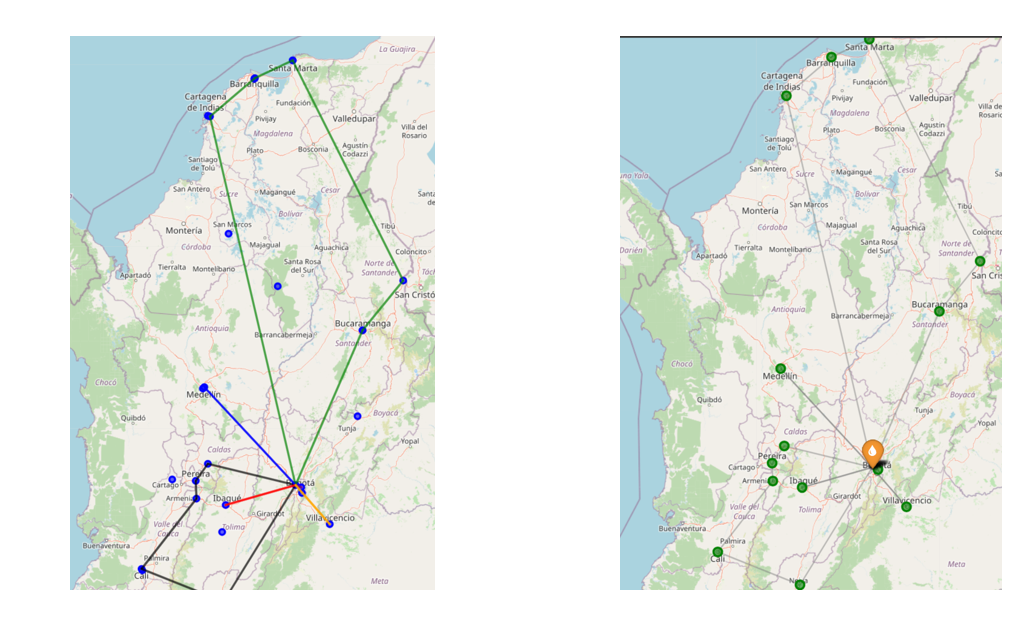

### 1. Gráficas de resultado

En la **Ruta 3** (imagen 1), coloreada de **rojo**, observamos:

* **Secuencia**: PTO → MUN03 → EST01 → PTO, es decir Bogotá → municipio 03 → estación 01 → Bogotá.
* El municipio 03 (en el mapa, Ibagué) está a unos **457 km** de distancia (tal como lo indicaba la tabla: Distance = 457.1 km, Time ≈ 9.14 h).
* Tras llegar a Ibagué, el camión retorna directo a Bogotá, sin necesidad de recarga intermedia (la autonomía de 1 300 km le sobra).

En el **Mapa detallado** (imagen 1) vemos:

* El **icono naranja** (EST01) junto a Bogotá: punto de recarga, pero **no hay paradas activas** (ningún otro icono de recarga) porque `RefuelStops = 0` para todos los vehículos.
* Los **círculos verdes** en cada municipio confirman que en todos los casos la carga entregada está por debajo del máximo permitido (no aparece ningún marcador rojo).
* Las líneas grises parten todas de Bogotá (PTO) hacia cada municipio y de regreso, mostrando la estructura global de las seis rutas.

**Lo que nos dicen estos resultados:**

1. **No hubo paradas de recarga reales**
   Aunque el modelo permite recargar, con las autonomías actuales ningún vehículo agota combustible, por eso `RefuelStops = 0` y no se utilizan estaciones.

2. **Cumplimiento de peso garantizado**
   Todos los municipios visitados aparecen marcados en verde, indicando que la carga descargada en cada uno nunca excede su límite legal.

3. **Vehículos “tipo carretera” dominan las rutas largas**
   – La Ruta 3 (“rojo”) es un tramo único de ida y vuelta a Ibagué (\~457 km).
   – Rutas más largas (Camiones 1 y 2, en verde y negro) agrupan múltiples municipios en un solo recorrido, aprovechando su mayor capacidad y autonomía.

4. **Estrategia de peajes**
   Cada vehículo paga un solo peaje (TollsVisited = 1, TollCost = 25 000 COP), por lo que conviene consolidar la mayor demanda posible en una visita a cada municipio para amortizar ese costo fijo.


### 2. Tablas por vehículo


El DataFrame resumen muestra, para cada CAM0XX:

| Vehículo | Recarga Total (gal) | Costo Combustible | Costo Peajes |      Costo Mant.     |  Distancia (km)  |    Tiempo (h)   | Peso Transportado (kg) | Peso Máximo (kg) |
| :------: | :-----------------: | :---------------: | :----------: | :------------------: | :--------------: | :-------------: | :--------------------: | :--------------: |
|  CAM001  |         0.0         |         0         |    25 000    |       1 135 890      |      1 622.7     |      32.45      |          67.6          |        80        |
|  CAM002  |         0.0         |         0         |    25 000    |        531 510       |       759.3      |      15.19      |          57.6          |        60        |
| CAM003–6 |         0.0         |         0         |    25 000    | 319 970 / 13 580 / … | 457.1 / 19.4 / … | 9.14 / 0.39 / … |     18.0 / 16.0 / …    |    50 / 40 / …   |

* **Recargas**: siempre 0 gal.
* **Peajes**: exactamente 25 000 COP por ruta, pues cada vehículo paga un solo peaje.
* **Mantenimiento** domina el costo operativo (700 COP/km).
* **Peso vs capacidad**: en todos los casos, la carga está por debajo de la capacidad y del máximo legal por municipio.


### 3. Análisis de sensibilidad

Se probaron tres escenarios:

1. **+20 % precio estaciones clave**
2. **–20 % autonomía de la flota**
3. **Exclusión de estaciones EST02 y EST03**

|    Escenario    | DistTotal (km) | CostTotal (COP) | Recargas | Peajes (COP) |
| :-------------: | :------------: | :-------------: | :------: | :----------: |
|   precio +20 %  |     3 284.3    |    18 870 963   |     0    |    150 000   |
| autonomia –20 % |     3 284.3    |    18 870 963   |     0    |    150 000   |
|  sin-estaciones |     3 284.3    |    18 870 963   |     0    |    150 000   |

**Ningún escenario alteró** ni las rutas, ni la distancia total, ni los costos, porque en el caso base **no se detuvo a recargar**. Por tanto, reducir la autonomía un 20 % o subir el precio de las estaciones no empujó al modelo a recargar; mantener o quitar estaciones tampoco cambió la solución óptima.

### 4. Preguntas

1. **¿Dónde debería LogistiCo establecer acuerdos con estaciones para minimizar costos?**
   Bajo los parámetros actuales no hubo necesidad de recarga. Sin embargo, la única estación por la que pasan algunos vehículos es EST01, por lo que, de planear recargas en escenarios de autonomía más estricta, EST01 sería la prioridad para negociar tarifas preferenciales.

2. **¿Qué tipo de camiones son más eficientes según el patrón de demanda?**
   Los vehículos con mayor autonomía y capacidad (p.ej. CAM001: 80 kg, 1 720 km de alcance; CAM002: 60 kg, 1 510 km) consolidan 5 municipios en un solo recorrido largo, reduciendo la cantidad de rutas necesarias y, por ende, los peajes.

3. **¿Cómo afectan los peajes variables la asignación óptima de rutas?**
   Con un peaje fijo por ruta, el modelo agrupa tantos municipios como la capacidad lo permita para pagar un solo peaje. Si los peajes fueran más altos en ciertas rutas, el modelo tendería a evitar esos arcos o a descargar parte de la demanda en otros vehículos, priorizando trayectos sin peaje o con peaje menor.